In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from figures.figureCommon import subplotLabel, getSetup
from tensorly.metrics.regression import variance as tl_var
from dataHelpers import importLINCSprotein, ohsu_data
from Data_Mod import LINCSCleanUp, dataCleanUp, form_parafac2_tensor, ohsu_var
from tensor import OHSU_parafac2_decomp, R2Xparafac2, projections_to_factors

In [42]:
p2slices, treatmentsTime, proteins, chromosomes, IFproteins, histones, geneExpression, RNAGenes, Rproteins = form_parafac2_tensor()
p2slicesB = ohsu_var(p2slices)

In [7]:
r2x = []
components = 5
for i in range(1, components + 1):
    parafac2tensor, error = OHSU_parafac2_decomp(p2slicesB, i)
    r2x.append(R2Xparafac2(p2slicesB, parafac2tensor))

In [8]:
df = pd.DataFrame(r2x)

comps = []
for i in range(1, components + 1):
    comps.append(i)
df['Component'] = comps

df.columns = ['Proteins', 'Chromosomes', 'IFproteins', 'Histones', 'Gene Expression', 'RNA Genes', 'RPPA Proteins', 'Component']
test = pd.melt(df, id_vars=['Component'])

(0.0, 1.0)

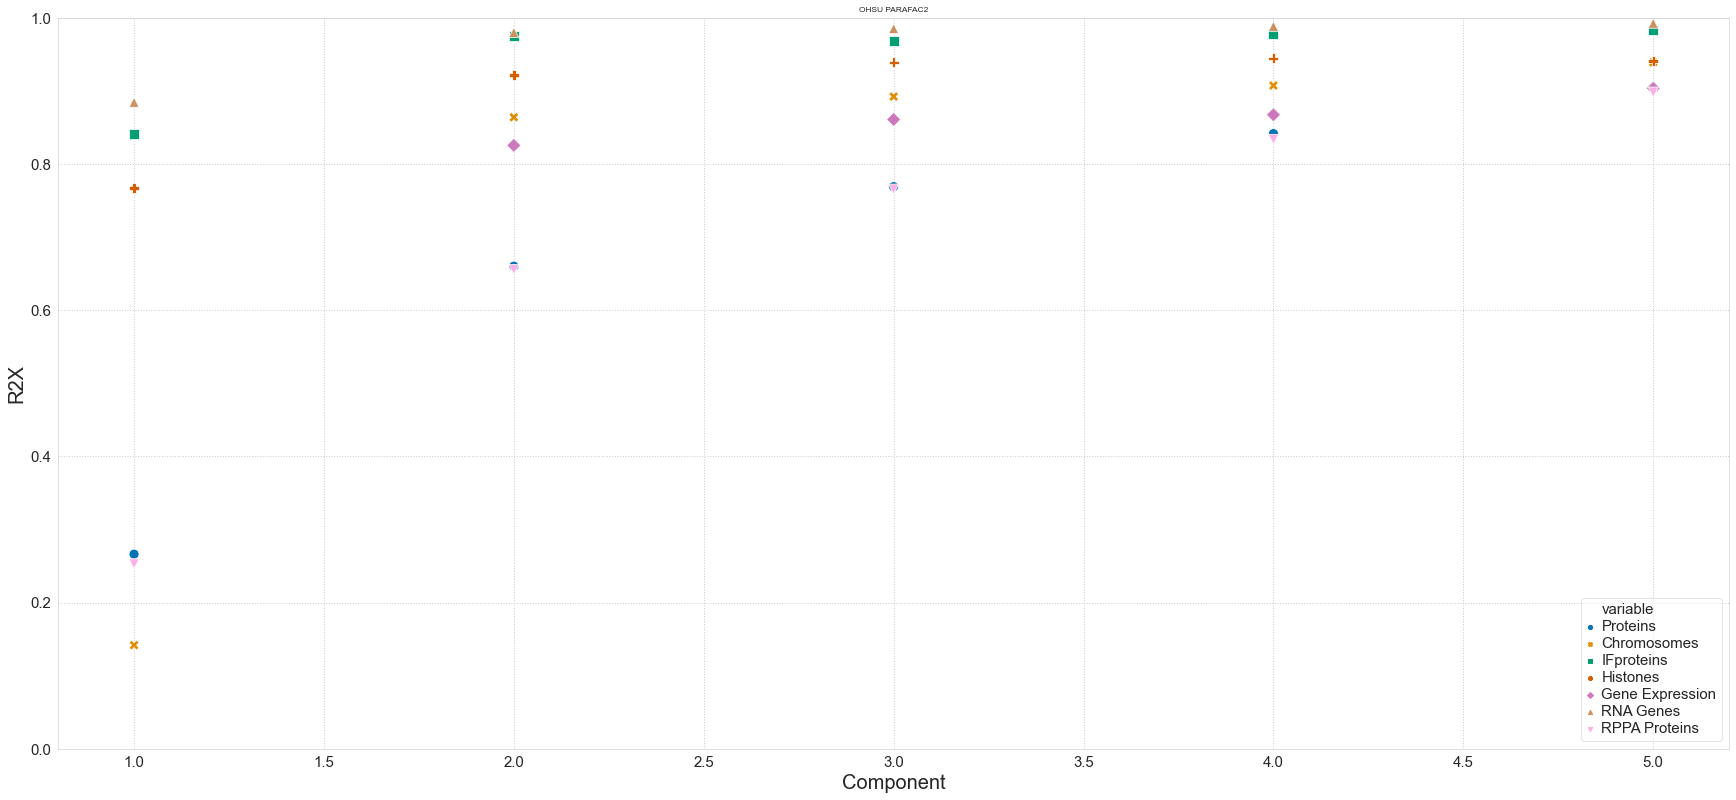

In [9]:
ax, f = getSetup((24, 11), (1, 1))
b = sns.scatterplot(data=test, x='Component', y='value', hue='variable', style='variable', ax=ax[0], s=100)
b.set_xlabel("Component", fontsize=20)
b.set_ylabel("R2X", fontsize=20)
b.set_title("OHSU PARAFAC2")
b.tick_params(labelsize=15)
plt.legend(prop={'size': 15})
ax[0].set_ylim(0, 1)

In [43]:
parafac2tensor, error = OHSU_parafac2_decomp(p2slicesB, 5)

In [44]:
weights, transform = projections_to_factors(parafac2tensor)

In [45]:
LINCSproteins = transform[1][0]
atacChr = transform[1][1]
GCPHistones = transform[1][3]
L1000GeneExp = transform[1][4]
RNAGeneSeq = transform[1][5]
RPPAproteins = transform[1][6]
#proteins, chromosomes, IFproteins, histones, geneExpression, RNAGenes, Rproteins

In [55]:
def outliersForPlot(transform, sliceRows):
    '''Determines outliers based on IQR range by component and returns dictionary by component that allows annotation for OHSU PARAFAC2 analysis'''
    df = transform.copy(deep=True)
    df['Proteins'] = sliceRows
    Q1 = df.quantile(.25)
    Q3 = df.quantile(.75)
    IQR = Q3 - Q1
    prots = {}
    for i in range(df.columns.size - 1):
        prots[i] = []
        for _, col in df.iterrows():
            if (col[i] < (Q1[i] - 1.7 * IQR[i])) or (col[i] > (Q3[i] + 1.7 * IQR[i])):
                tup = [i, col[i], col['Proteins'][:-1], True, True]
                prots[i].append(tup)
        prots[i].sort(key=lambda x: x[1])
        for idx, tup in enumerate(prots[i]):
            if idx < len(prots[i]) - 4:
                if tup[1] > prots[i][idx + 2][1] - .012 and tup[3] == tup[4]:
                    random1 = np.random.choice([0, 1, 1])
                    prots[i][idx + (random1 * 2)][3] = False
                    tup[4] = False
                    prots[i][idx + 2][4] = False
                elif tup[1] > prots[i][idx + 2][1] - .012 and tup[3]:
                    prots[i][idx + 2][3] = False
                    prots[i][idx + 2][4] = False
                if tup[1] > prots[i][idx + 4][1] - .012 and tup[3]:
                    random2 = np.random.randint(0, 2)
                    prots[i][idx + random2 * 4][3] = False
                    prots[i][idx + 4][4] = False
    return prots

In [53]:
def proteinBoxPlot(ax, transformed, componentIn, sliceRows):
    '''Plots protein component in partial tucker factorization space with annotation of some outliers'''
    df = pd.DataFrame(transformed)
    prots = outliersForPlot(df, sliceRows)
    sns.boxplot(data=df, ax=ax)
    ax.set_xlabel("Component " + str(componentIn))
    ax.set_ylabel('Component Value')
    ax.set_title('Protein Factors')
    for component in prots:
        offset_side = 0
        for outlier in prots[component]:
            if outlier[3]:
                if offset_side == 0:
                    ax.text(outlier[0] + .05, outlier[1] - .005, outlier[2], horizontalalignment='left', size='large', color='black', weight=100)
                    offset_side = 1
                elif offset_side == 1:
                    ax.text(outlier[0] - .05, outlier[1] - .005, outlier[2], horizontalalignment='right', size='large', color='black', weight=100)
                    offset_side = 0
            else:
                offset_side = 1 - offset_side

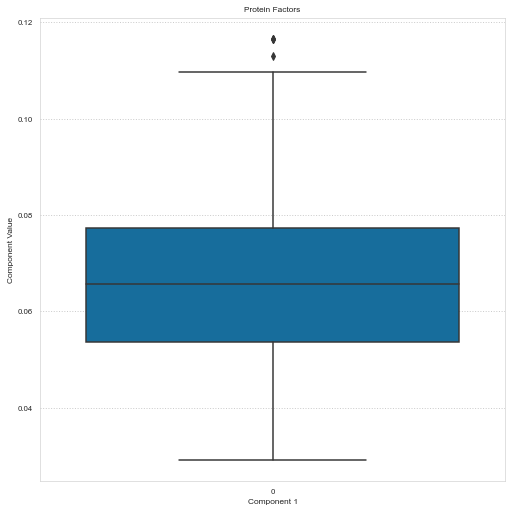

In [63]:
ax, f = getSetup((7, 7), (1, 1))
proteinBoxPlot(ax[0], L1000GeneExp[:, 0], 1, geneExpression)

In [64]:
def transformPlot(seed, transformSlice, sliceRow):
    col = np.size(transformSlice, 1)
    for a in range(col):
        proteinBoxPlot(ax[seed + a], transformSlice[:,a], a+1, sliceRow)

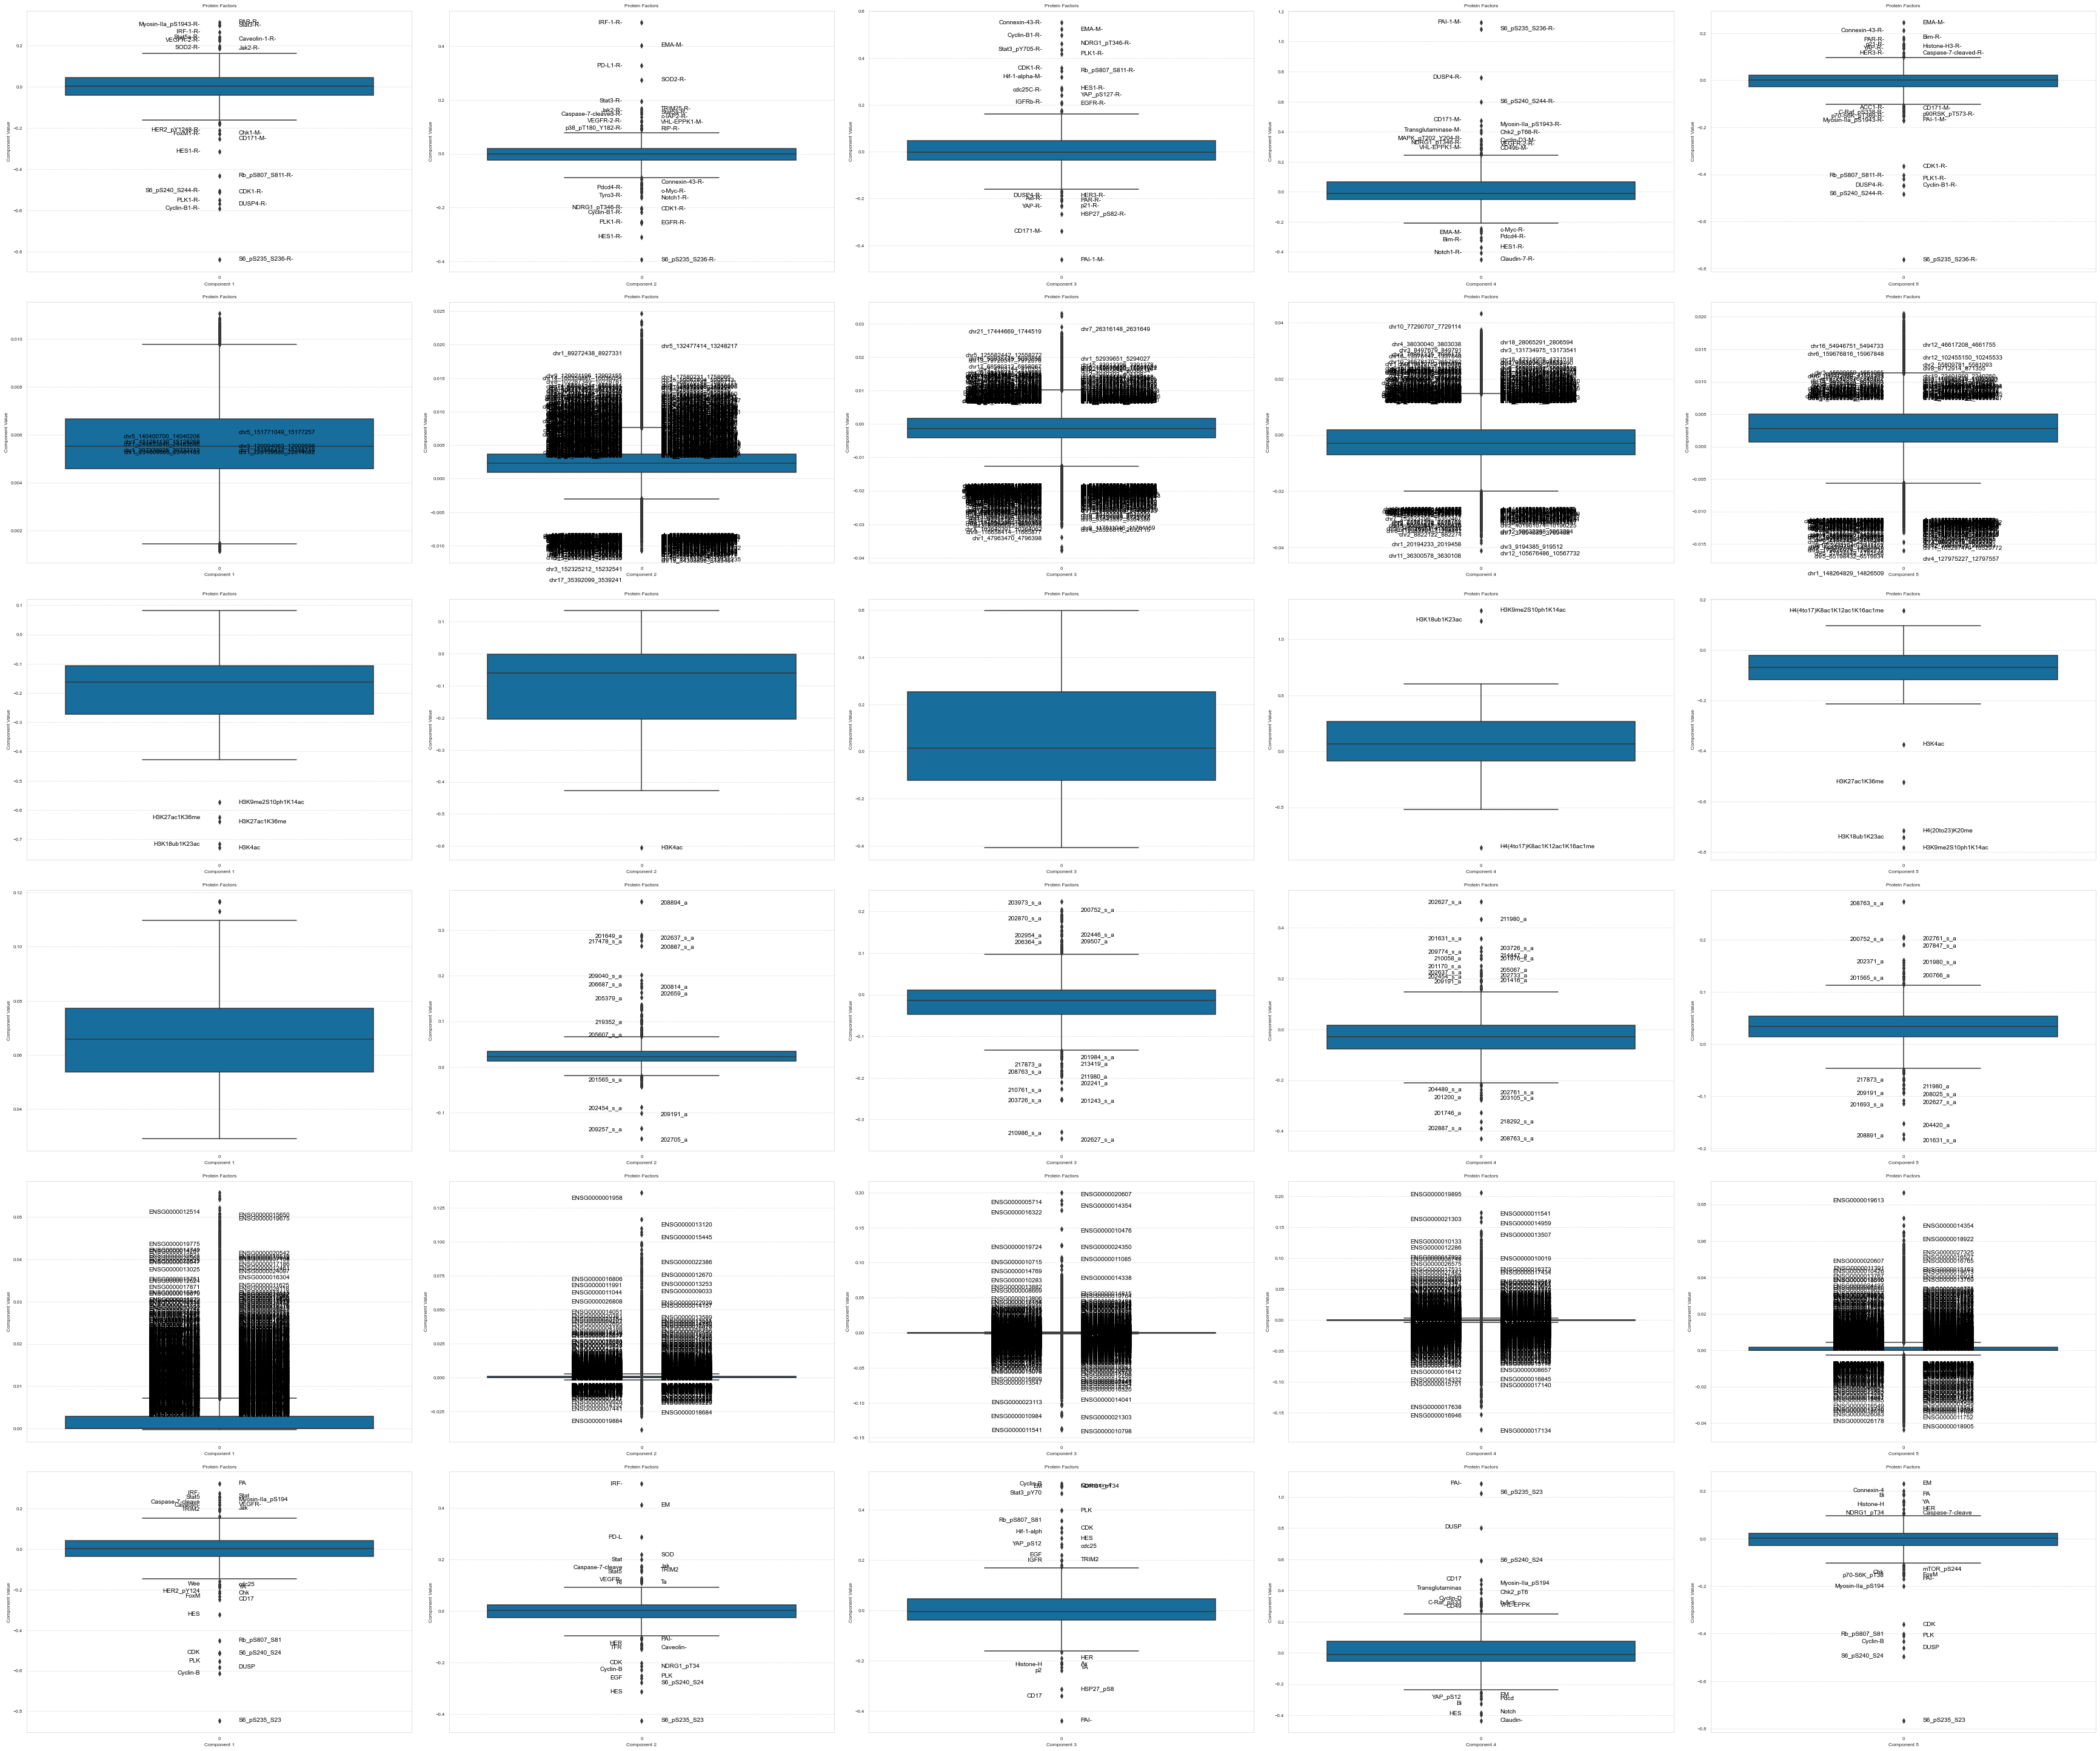

In [66]:
row = 6
col = 5
ax, f = getSetup((48, 40), (row, col))
transformPlot(0, LINCSproteins, proteins)
transformPlot(5, atacChr, chromosomes)
transformPlot(10, GCPHistones, histones)
transformPlot(15, L1000GeneExp, geneExpression)
transformPlot(20, RNAGeneSeq, RNAGenes)
transformPlot(25, RPPAproteins, Rproteins)

In [5]:
C = parafac2tensor[1][2]

In [7]:
D = parafac2tensor[2][0]
print(D.shape)

(295, 7)


<Figure size 432x288 with 0 Axes>

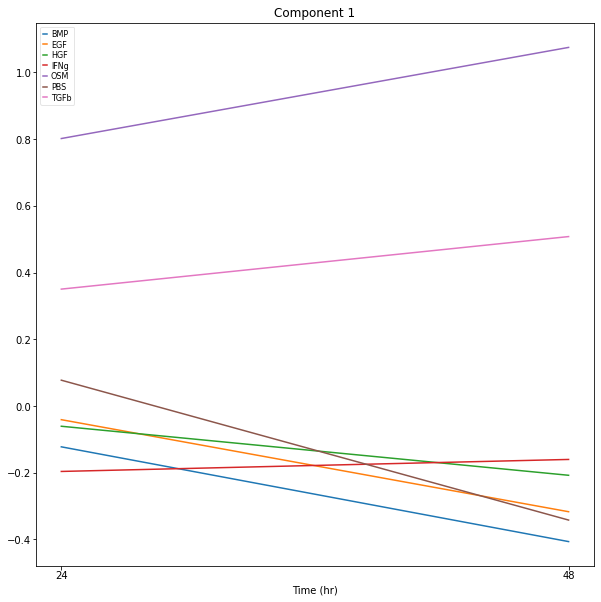

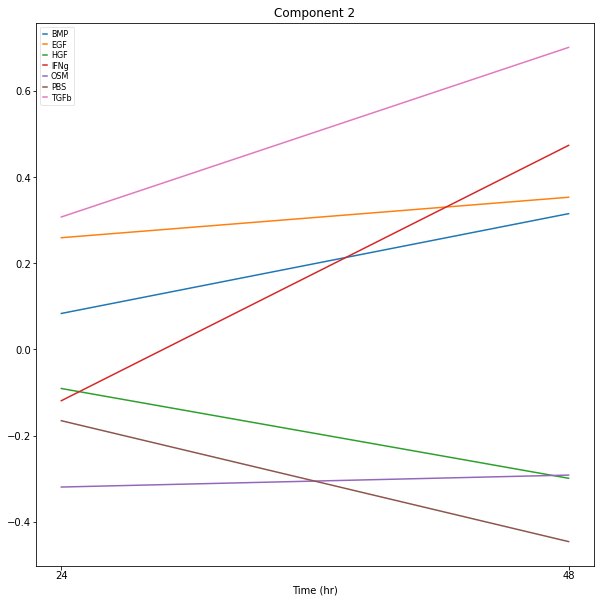

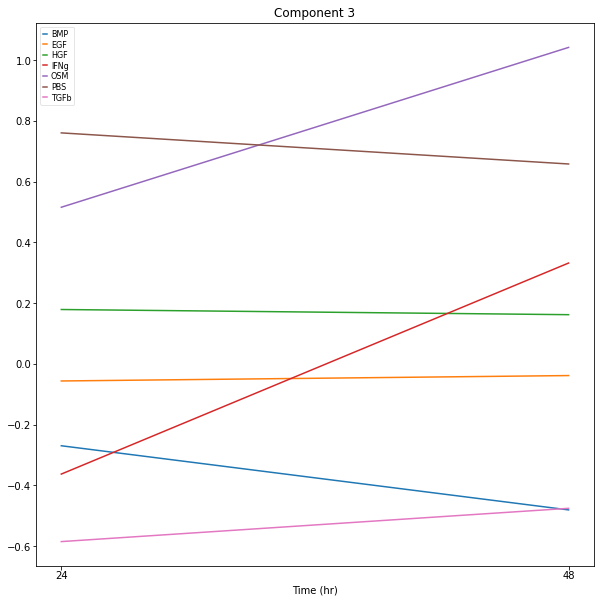

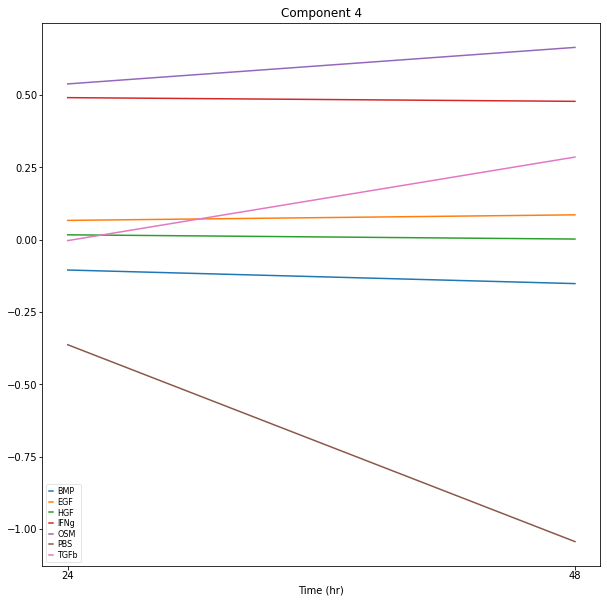

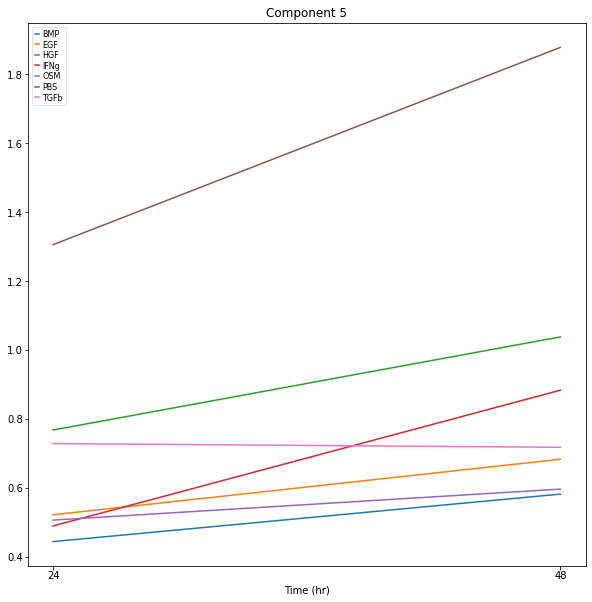

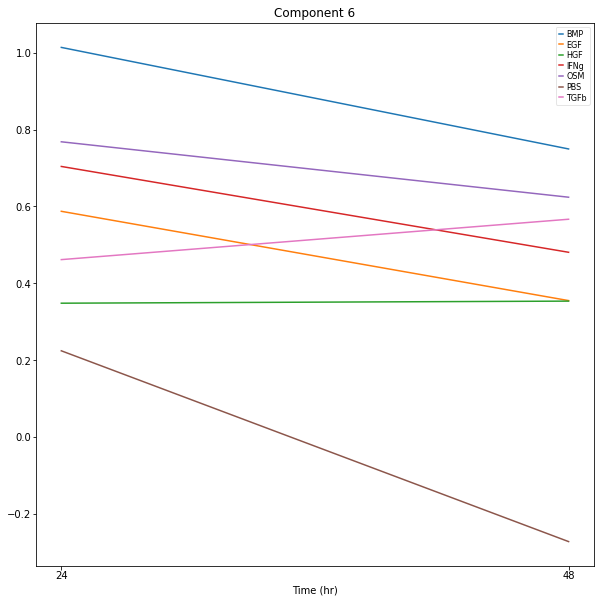

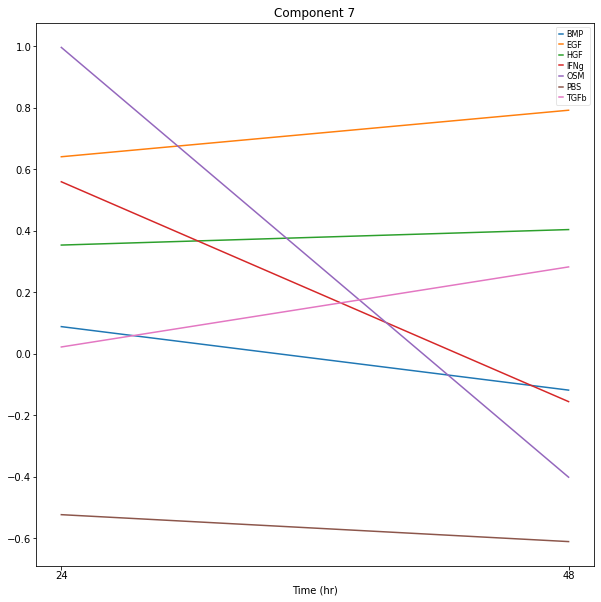

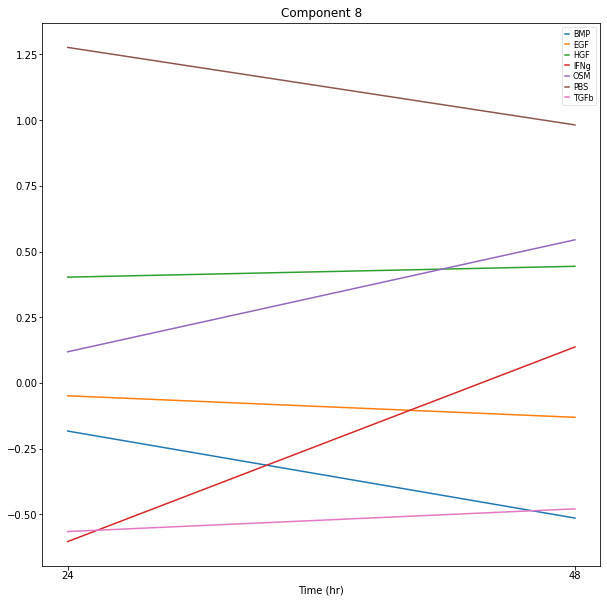

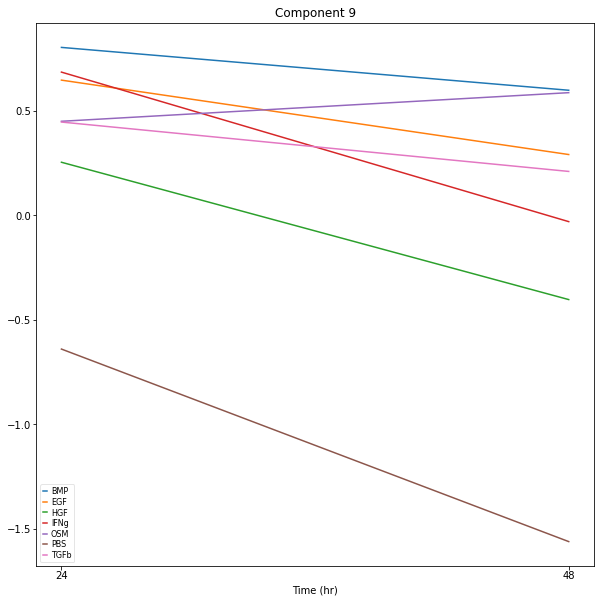

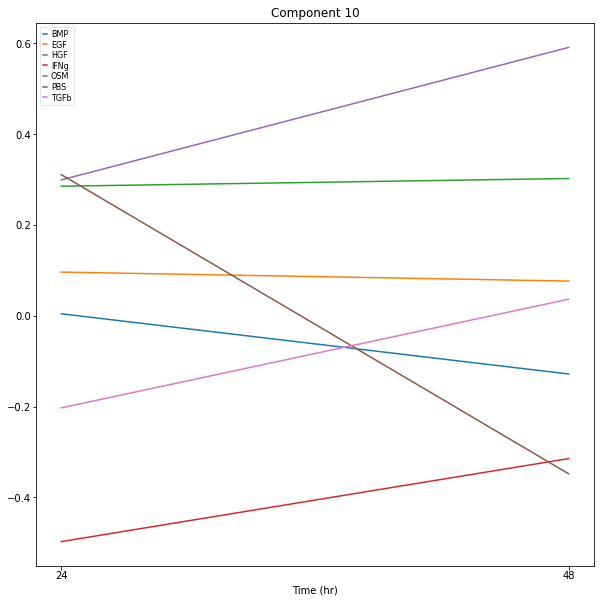

In [19]:
components = 10
treatments = ['BMP2_24', 'BMP2_48', 'EGF_24', 'EGF_48', 'HGF_24', 'HGF_48', 'IFNg_24', 'IFNg_48', 'OSM_24', 'OSM_48', 'PBS_24', 'PBS_48', 'TGFb_24', 'TGFb_48']
df = pd.DataFrame(C, index = treatments)
trmt = df.to_numpy()
for x in range(10):
    BMP, EGF, HGF, IFNg, OSM, PBS, TGFb = [], [], [], [], [], [], []
    plt.figure(x)
    plt.figure(figsize=(10,10))
    plt.xticks([0,1], ['24','48'])
    plt.xlabel('Time (hr)')
    plt.title('Component ' + str(x+1))
    for y in range(7):
        if y == 0:
            BMP.append(trmt[(y*2), x])
            BMP.append(trmt[(y*2)+1,x])
        elif y == 1:
            EGF.append(trmt[(y*2), x])
            EGF.append(trmt[(y*2)+1,x])
        elif y == 2:
            HGF.append(trmt[(y*2), x])
            HGF.append(trmt[(y*2)+1, x])
        elif y == 3:
            IFNg.append(trmt[(y*2), x])
            IFNg.append(trmt[(y*2)+1, x])
        elif y == 4:
            OSM.append(trmt[(y*2), x])
            OSM.append(trmt[(y*2)+1, x])
        elif y == 5:
            PBS.append(trmt[(y*2), x])
            PBS.append(trmt[(y*2)+1, x])
        elif y == 6:
            TGFb.append(trmt[(y*2), x])
            TGFb.append(trmt[(y*2)+1, x])
    plt.plot(BMP)
    plt.plot(EGF)
    plt.plot(HGF)
    plt.plot(IFNg)
    plt.plot(OSM)
    plt.plot(PBS)
    plt.plot(TGFb)
    plt.legend(['BMP', 'EGF', 'HGF', 'IFNg', 'OSM', 'PBS', 'TGFb'])
        

In [11]:
C = parafac2tensor[1][2]
components = 10
treatments = ['BMP2_24', 'BMP2_48', 'EGF_24', 'EGF_48', 'HGF_24', 'HGF_48', 'IFNg_24', 'IFNg_48', 'OSM_24', 'OSM_48', 'PBS_24', 'PBS_48', 'TGFb_24', 'TGFb_48']
df = pd.DataFrame(C, index = treatments, columns = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
for x in range(10):
    for y in range(7):
        if y == 0:
            BMP1 = df.loc['BMP2_24':'BMP2_48', str(x+1)]
        elif y == 1:
            EGF1 = df.loc['EGF_24':'EGF_48', str(x+1)]
        elif y == 2:
            HGF1 = df.loc['HGF_24':'HGF_48', str(x+1)]
        elif y == 3:
            IFNg1 = df.loc['IFNg_24':'IFNg_48', str(x+1)]
        elif y == 4:
            OSM1 = df.loc['OSM_24':'OSM_48', str(x+1)]
        elif y == 5:
            PBS1 = df.loc['PBS_24':'PBS_48', str(x+1)]
        elif y == 6:
            TGFb1 = df.loc['TGFb_24':'TGFb_48', str(x+1)]
    BMP1['Time'] = [24, 48]
    EGF1['Time'] = [24, 48]
    HGF1['Time'] = [24, 48]
    IFNg1['Time'] = [24, 48]
    OSM1['Time'] = [24, 48]
    PBS1['Time'] = [24, 48]
    TGFb1['Time'] = [24, 48]
    BMP1 = BMP1.set_index('Time')
    EGF1 = EGF1.set_index('Time')
    HGF1 = HGF1.set_index('Time')
    IFNg1 = IFNg1.set_index('Time')
    OSM1 = OSM1.set_index('Time')
    PBS1 = PBS1.set_index('Time')
    TGFb1 = TGFb1.set_index('Time')
    b = sns.lineplot(data=BMP1, ax=ax[x], dashes=None)
    b = sns.lineplot(data=EGF1, ax=ax[x], dashes=None)
    b = sns.lineplot(data=HGF1, ax=ax[x], dashes=None)
    b = sns.lineplot(data=IFNg1, ax=ax[x], dashes=None)
    b = sns.lineplot(data=OSM1, ax=ax[x], dashes=None)
    b = sns.lineplot(data=PBS1, ax=ax[x], dashes=None)
    b = sns.lineplot(data=TGFb1, ax=ax[x], dashes=None)
    b.set_title('Component ' + str(x + 1))
for i in range(components + 1, len(ax)):
    ax[i].axis('off'

AttributeError: 'Series' object has no attribute 'set_index'